In [95]:
from keras.models import Model
from keras.layers import Input, Activation, Conv1D, Lambda, Add, Multiply, BatchNormalization
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
import random
import pickle
import glob
from tqdm import tqdm
import os

from python_speech_features import mfcc
import scipy.io.wavfile as wav
import librosa
from IPython.display import Audio

import csv

In [116]:
with open('./train-toneless_update.csv', newline='', errors='ignore') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
        if row[0] != 'id':
            a=row[0]
            b=row[1].lower()
            f=open('./train/txt/' + a + '.txt', 'w')
            f.write(b)
            f.close()

In [117]:
def get_wav_files(wav_path):
    wav_files = []
    for (dirpath, dirname, filenames) in os.walk(wav_path):
        for filename in filenames:
            if filename.endswith('.wav') or filename.endswith('.WAV'):
                filename_path = os.path.join(dirpath, filename)
                wav_files.append(filename_path)
    return wav_files

def get_tran_texts(wav_files, tran_path):
    tran_texts = []
    for wav_file in wav_files:
        basename = os.path.basename(wav_file)
        x = os.path.splitext(basename)[0]
        tran_file = os.path.join(tran_path, x+'.txt')
        if os.path.exists(tran_file) is False:
            return None
        fd = open(tran_file, 'r')
        text = fd.readline()
        tran_texts.append(text.split('\n')[0])
        fd.close()
    return tran_texts

In [118]:
paths = get_wav_files('./train')
texts = get_tran_texts(paths, './train/txt')

In [119]:
print(texts[0])
print(paths[0])

phue ka gua kheh khi khuann lah lang gua tok sin lah
./train/981.wav


Audio Text: phue ka gua kheh khi khuann lah lang gua tok sin lah


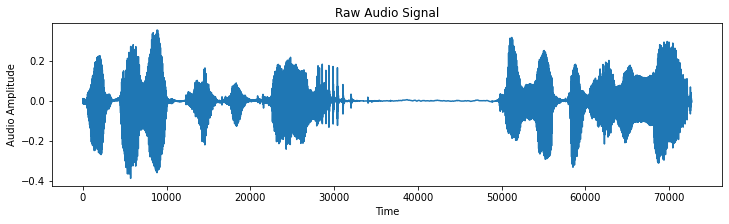

Shape of MFCC: (328, 13)


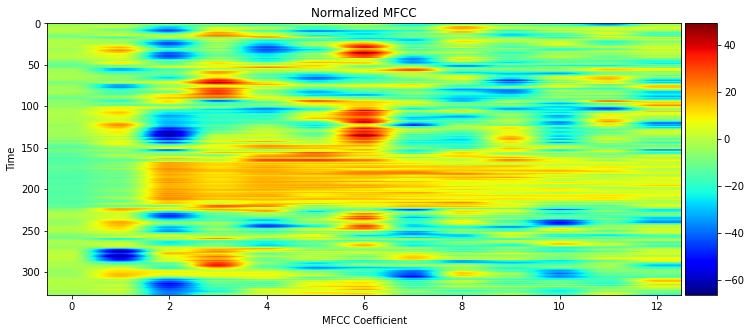

In [120]:
mfcc_dim = 13

def load_and_trim(path):
    audio, sr = librosa.load(path)
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy)/10)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    
    return audio, sr

def visualize(index):
    path = paths[index]
    text = texts[index]
    print('Audio Text:', text)
    
    audio, sr = load_and_trim(path)
    plt.figure(figsize=(12, 3))
    plt.plot(np.arange(len(audio)), audio)
    plt.title('Raw Audio Signal')
    plt.xlabel('Time')
    plt.ylabel('Audio Amplitude')
    plt.show()
    
    feature = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    print('Shape of MFCC:', feature.shape)
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Normalized MFCC')
    plt.ylabel('Time')
    plt.xlabel('MFCC Coefficient')
    plt.colorbar(im, cax=make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05))
    ax.set_xticks(np.arange(0, 13, 2), minor=False);
    plt.show()
    
    return path

Audio(visualize(0))

In [121]:
total = len(paths)
features = []
for i in tqdm(range(total)):
    path = paths[i]
    audio, sr = load_and_trim(path)
    features.append(mfcc(audio, sr, numcep=mfcc_dim, nfft=551))
    
print(len(features), features[0].shape)

100%|██████████| 3119/3119 [00:42<00:00, 73.72it/s]

3119 (328, 13)


In [122]:
samples = random.sample(features, 100)
samples = np.vstack(samples)

mfcc_mean = np.mean(samples, axis=0)
mfcc_std = np.std(samples, axis=0)
print(mfcc_mean)
print(mfcc_std)

features = [(feature - mfcc_mean) / (mfcc_std + 1e-14) for feature in features]

[ -5.83416143  -4.74000486  -5.08206355  -0.04400054  -3.0903978
 -14.1018834    4.04681965  -9.77794067  -6.91585317  -6.24116851
 -12.43716095  -9.91439276  -6.89255486]
[ 3.7971149  16.4664863  19.33793646 18.94395916 16.11042989 18.174427
 14.95114651 15.28233791 14.97635431 13.51499373 13.96990488 12.10111418
 12.2853803 ]


In [123]:
chars = {}
for text in texts:
    text = text.lower()
    for c in text:
        chars[c] = chars.get(c, 0) + 1

chars = sorted(chars.items(), key=lambda x: x[1], reverse=True)
chars = [char[0] for char in chars]
print(len(chars), chars[:100])

char2id = {c: i for i, c in enumerate(chars)}
id2char = {i: c for i, c in enumerate(chars)}

27 [' ', 'i', 'a', 'n', 't', 'h', 's', 'u', 'o', 'k', 'g', 'e', 'l', 'p', 'b', 'm', 'j', 'r', 'c', 'd', 'f', 'y', 'v', 'w', 'x', 'q', 'z']


In [124]:
data_index = np.arange(total)
np.random.shuffle(data_index)
train_size = int(0.9 * total)
test_size = total - train_size
train_index = data_index[:train_size]
test_index = data_index[train_size:]

X_train = [features[i] for i in train_index]
Y_train = [texts[i] for i in train_index]
X_test = [features[i] for i in test_index]
Y_test = [texts[i] for i in test_index]

batch_size = 4

def batch_generator(x, y, batch_size=batch_size):  
    offset = 0
    while True:
        offset += batch_size
        
        if offset == batch_size or offset >= len(x):
            data_index = np.arange(len(x))
            np.random.shuffle(data_index)
            x = [x[i] for i in data_index]
            y = [y[i] for i in data_index]
            offset = batch_size
            
        X_data = x[offset - batch_size: offset]
        Y_data = y[offset - batch_size: offset]
        
        X_maxlen = max([X_data[i].shape[0] for i in range(batch_size)])
        Y_maxlen = max([len(Y_data[i]) for i in range(batch_size)])
        
        X_batch = np.zeros([batch_size, X_maxlen, mfcc_dim])
        Y_batch = np.ones([batch_size, Y_maxlen]) * len(char2id)
        X_length = np.zeros([batch_size, 1], dtype='int32')
        Y_length = np.zeros([batch_size, 1], dtype='int32')
        for i in range(batch_size):
            X_length[i, 0] = X_data[i].shape[0]
            X_batch[i, :X_length[i, 0], :] = X_data[i]
            
            Y_length[i, 0] = len(Y_data[i])
            Y_batch[i, :Y_length[i, 0]] = [char2id[c] for c in Y_data[i]]
            
        inputs = {'X': X_batch, 'Y': Y_batch, 'X_length': X_length, 'Y_length': Y_length}
        outputs = {'ctc': np.zeros([batch_size])}
        yield (inputs, outputs)

In [126]:
epochs = 50
num_blocks = 3
filters = 128

X = Input(shape=(None, mfcc_dim,), dtype='float32', name='X')
Y = Input(shape=(None,), dtype='float32', name='Y')
X_length = Input(shape=(1,), dtype='int32', name='X_length')
Y_length = Input(shape=(1,), dtype='int32', name='Y_length')

def conv1d(inputs, filters, kernel_size, dilation_rate):
    return Conv1D(filters=filters, kernel_size=kernel_size, strides=1, padding='causal', activation=None, dilation_rate=dilation_rate)(inputs)

def batchnorm(inputs):
    return BatchNormalization()(inputs)

def activation(inputs, activation):
    return Activation(activation)(inputs)

def res_block(inputs, filters, kernel_size, dilation_rate):
    hf = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'tanh')
    hg = activation(batchnorm(conv1d(inputs, filters, kernel_size, dilation_rate)), 'sigmoid')
    h0 = Multiply()([hf, hg])
    
    ha = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    hs = activation(batchnorm(conv1d(h0, filters, 1, 1)), 'tanh')
    
    return Add()([ha, inputs]), hs

h0 = activation(batchnorm(conv1d(X, filters, 1, 1)), 'tanh')
shortcut = []
for i in range(num_blocks):
    for r in [1, 2, 4, 8, 16]:
        h0, s = res_block(h0, filters, 7, r)
        shortcut.append(s)

h1 = activation(Add()(shortcut), 'relu')
h1 = activation(batchnorm(conv1d(h1, filters, 1, 1)), 'relu')
Y_pred = activation(batchnorm(conv1d(h1, len(char2id) + 1, 1, 1)), 'softmax')
sub_model = Model(inputs=X, outputs=Y_pred)

def calc_ctc_loss(args):
    y, yp, ypl, yl = args
    return K.ctc_batch_cost(y, yp, ypl, yl)

ctc_loss = Lambda(calc_ctc_loss, output_shape=(1,), name='ctc')([Y, Y_pred, X_length, Y_length])
model = Model(inputs=[X, Y, X_length, Y_length], outputs=ctc_loss)
optimizer = SGD(lr=0.02, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda ctc_true, ctc_pred: ctc_pred}, optimizer=optimizer)

checkpointer = ModelCheckpoint(filepath='asr.h5', verbose=0)
lr_decay = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=1, min_lr=0.000)

history = model.fit_generator(
    generator=batch_generator(X_train, Y_train), 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs, 
    validation_data=batch_generator(X_test, Y_test), 
    validation_steps=len(X_test) // batch_size, 
    callbacks=[checkpointer, lr_decay])

Epoch 1/50
701/701 [==============================] - 163s 232ms/step - loss: 91.9977 - val_loss: 41.0778
Epoch 2/50
701/701 [==============================] - 95s 135ms/step - loss: 38.4660 - val_loss: 31.2448
Epoch 3/50
701/701 [==============================] - 93s 133ms/step - loss: 31.7718 - val_loss: 29.5344
Epoch 4/50
701/701 [==============================] - 94s 135ms/step - loss: 27.1142 - val_loss: 27.6765
Epoch 5/50
701/701 [==============================] - 93s 132ms/step - loss: 23.7023 - val_loss: 24.9675
Epoch 6/50
701/701 [==============================] - 93s 132ms/step - loss: 20.8812 - val_loss: 26.7374
Epoch 7/50
701/701 [==============================] - 93s 132ms/step - loss: 18.5826 - val_loss: 27.1020
Epoch 8/50
701/701 [==============================] - 93s 132ms/step - loss: 16.7821 - val_loss: 31.7771
Epoch 9/50
701/701 [==============================] - 95s 135ms/step - loss: 14.5040 - val_loss: 23.6634
Epoch 10/50
701/701 [==============================] -

In [127]:
sub_model.save('asr.h5')
with open('dictionary.pkl', 'wb') as fw:
    pickle.dump([char2id, id2char, mfcc_mean, mfcc_std], fw)

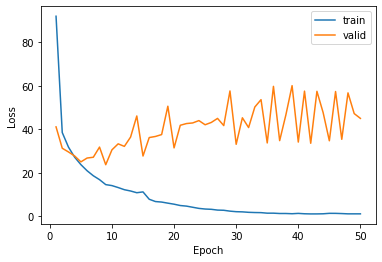

In [128]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']
plt.plot(np.linspace(1, epochs, epochs), train_loss, label='train')
plt.plot(np.linspace(1, epochs, epochs), valid_loss, label='valid')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [129]:
from keras.models import load_model
import pickle

with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

sub_model = load_model('asr.h5')

def random_predict(x, y):
    index = np.random.randint(len(x))
    feature = x[index]
    text = y[index]
    
    pred = sub_model.predict(np.expand_dims(feature, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [feature.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    
    print('True transcription:\n-- ', text, '\n')
    print('Predicted transcription:\n-- ' + ''.join([id2char[i] for i in pred_ids]), '\n')

random_predict(X_train, Y_train)
random_predict(X_test, Y_test)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


True transcription:
--  phue i sia kue ah 

Predicted transcription:
-- phue i sia kue ah 

True transcription:
--  tshit pah kau tsap it phinn iong tsok gi sia kong bun tshua ing bun guan tsu bin tsuan hing tsing gi huah tua poo 

Predicted transcription:
-- tshit pah kau tsap it phin iong tsok gi sia kong bun tshua ing bun guan tsu bin tsuan hing tsing i hua tua po 



In [133]:
from keras.models import load_model
from keras import backend as K
import numpy as np
import librosa
from python_speech_features import mfcc
import pickle
import glob

wavs = glob.glob('./test-shuf/*.wav')
with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

mfcc_dim = 13
model = load_model('asr.h5')

index = np.random.randint(len(wavs))
print(wavs[index])

audio, sr = librosa.load(wavs[index])
energy = librosa.feature.rms(audio)
frames = np.nonzero(energy >= np.max(energy) / 10)
indices = librosa.core.frames_to_samples(frames)[1]
audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
X_data = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
X_data = (X_data - mfcc_mean) / (mfcc_std + 1e-14)
print(X_data.shape)

'''with open(wavs[index] + '.txt', 'r', encoding='utf8') as fr:
    label = fr.readlines()[0]
    print(label)'''

pred = model.predict(np.expand_dims(X_data, axis=0))
pred_ids = K.eval(K.ctc_decode(pred, [X_data.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
pred_ids = pred_ids.flatten().tolist()
print(''.join([id2char[i] for i in pred_ids]))

./test-shuf/25.wav
(279, 13)
lan hun san tsiong tsing hing lai tho lun


In [143]:
x = ''.join([id2char[i] for i in pred_ids])
print(x)

lan hun san tsiong tsing hing lai tho lun


In [1]:
from keras.models import load_model
from keras import backend as K
import numpy as np
import librosa
from python_speech_features import mfcc
import pickle
import glob

wavs = glob.glob('./test-shuf/*.wav')
with open('dictionary.pkl', 'rb') as fr:
    [char2id, id2char, mfcc_mean, mfcc_std] = pickle.load(fr)

mfcc_dim = 13
model = load_model('asr.h5')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
text_path = []
for i in range(346):
    text_path.append('./test-shuf/'+str(i+1)+'.wav')

result = []
for wavs in text_path:
    audio, sr = librosa.load(wavs)
    energy = librosa.feature.rms(audio)
    frames = np.nonzero(energy >= np.max(energy) / 10)
    indices = librosa.core.frames_to_samples(frames)[1]
    audio = audio[indices[0]:indices[-1]] if indices.size else audio[0:0]
    X_data = mfcc(audio, sr, numcep=mfcc_dim, nfft=551)
    X_data = (X_data - mfcc_mean) / (mfcc_std + 1e-14)
    pred = model.predict(np.expand_dims(X_data, axis=0))
    pred_ids = K.eval(K.ctc_decode(pred, [X_data.shape[0]], greedy=False, beam_width=10, top_paths=1)[0][0])
    pred_ids = pred_ids.flatten().tolist()
    
    Y = ''.join([id2char[i] for i in pred_ids])
    result.append(Y)
result

['tse ho tsan se kai bing pang kah tiat lin khuan tsai kan la u punt li e ing hion',
 'ing am gua tsiah ka li tian lo',
 'ah be sian po',
 'si sit giam po so',
 'a sui kam mo a pai thok li the i tshing ka',
 'an ne lah',
 'li kiam bo kong iau u si gih jit tsiu siu kua e si kau ma gua ka lin kong gia ba khuan hng it king sik thang kua la',
 'a san a pa mi kue ah',
 'kiam pian tsiah ka khaon khaun ki',
 'san si siu go ho ki khit khu',
 'ti hia khuan e lang iah si sam sam go go tshin tshin tsng tsn',
 'khonh lai lai lai thain si tsiah thai sio tsiah',
 'i tsing li tai gi su lui tsong si tse si tua kang ting ma su iau siong se e kui ue',
 'li tsit e ho me me',
 'tui putin lai kong tse tai piau i kiong nge tui khong bi kok ka au tsiu tit tioh sing li',
 'thing loh lai e si sim lai kam u ban tsiok e kam kak sing khu na kian liau siun kin',
 'hong bun a',
 'o to ba si tsian ping siong e kau thong kang khu tsuan tai uan tshue bo lang be iau khiahu o to bai e',
 'kah hit tsam ti tsit tsun ji ts

In [6]:
len(result)

346

In [7]:
import csv
with open('output.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    
    writer.writerow(['id', 'text'])
    for i in range(346):
        writer.writerow([i+1, result[i]])